In [ ]:
conda create -n python3.8 python=3.8
conda install pytorch torchvision cpuonly -c pytorch

[Learn the Basics](intro.html) \|\| **Quickstart** \|\|
[Tensors](tensorqs_tutorial.html) \|\| [Datasets &
DataLoaders](data_tutorial.html) \|\|
[Transforms](transforms_tutorial.html) \|\| [Build
Model](buildmodel_tutorial.html) \|\|
[Autograd](autogradqs_tutorial.html) \|\|
[Optimization](optimization_tutorial.html) \|\| [Save & Load
Model](saveloadrun_tutorial.html)

Quickstart
==========

This section runs through the API for common tasks in machine learning.
Refer to the links in each section to dive deeper.

Working with data
-----------------

PyTorch has two [primitives to work with
data](https://pytorch.org/docs/stable/data.html):
`torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. `Dataset`
stores the samples and their corresponding labels, and `DataLoader`
wraps an iterable around the `Dataset`.


In [14]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

PyTorch offers domain-specific libraries such as
[TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and
[TorchAudio](https://pytorch.org/audio/stable/index.html), all of which
include datasets. For this tutorial, we will be using a TorchVision
dataset.

The `torchvision.datasets` module contains `Dataset` objects for many
real-world vision data like CIFAR, COCO ([full list
here](https://pytorch.org/vision/stable/datasets.html)). In this
tutorial, we use the FashionMNIST dataset. Every TorchVision `Dataset`
includes two arguments: `transform` and `target_transform` to modify the
samples and labels respectively.


In [11]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [12]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

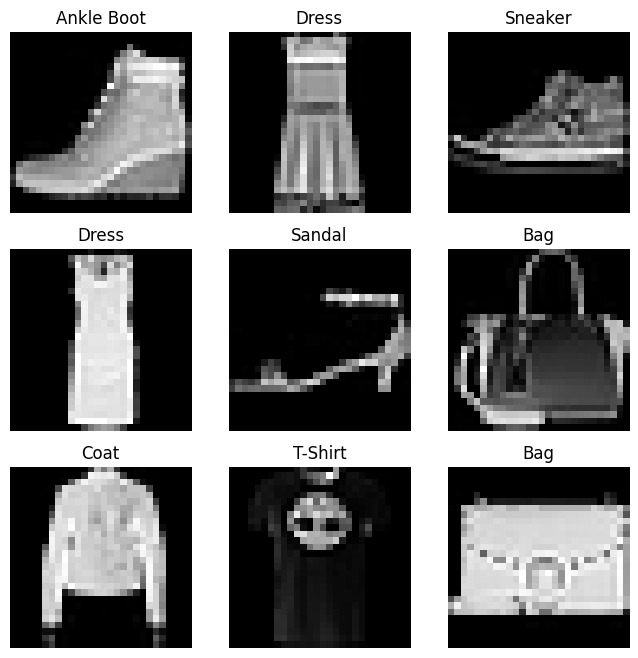

In [15]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

We pass the `Dataset` as an argument to `DataLoader`. This wraps an
iterable over our dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading. Here we define a batch size of
64, i.e. each element in the dataloader iterable will return a batch of
64 features and labels.


In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Read more about [loading data in PyTorch](data_tutorial.html).


------------------------------------------------------------------------


Creating Models
===============

To define a neural network in PyTorch, we create a class that inherits
from
[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
We define the layers of the network in the `__init__` function and
specify how data will pass through the network in the `forward`
function. To accelerate operations in the neural network, we move it to
the
[accelerator](https://pytorch.org/docs/stable/torch.html#accelerators)
such as CUDA, MPS, MTIA, or XPU. If the current accelerator is
available, we will use it. Otherwise, we use the CPU.


In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model (CNN version)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # First convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling layer

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Second convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        )

        self.flatten = nn.Flatten()
        self.fc_stack = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),  # Adjusted for CNN output shape
            nn.ReLU(),
            nn.Linear(512, 10)  # Output layer for 10 classes
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        logits = self.fc_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (conv_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_stack): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)


Read more about [building neural networks in
PyTorch](buildmodel_tutorial.html).


------------------------------------------------------------------------


Optimizing the Model Parameters
===============================

To train a model, we need a [loss
function](https://pytorch.org/docs/stable/nn.html#loss-functions) and an
[optimizer](https://pytorch.org/docs/stable/optim.html).


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training
dataset (fed to it in batches), and backpropagates the prediction error
to adjust the model\'s parameters.


In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model\'s performance against the test dataset to
ensure it is learning.


In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*).
During each epoch, the model learns parameters to make better
predictions. We print the model\'s accuracy and loss at each epoch;
we\'d like to see the accuracy increase and the loss decrease with every
epoch.


In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.292380  [   64/60000]
loss: 2.278174  [ 6464/60000]
loss: 2.252452  [12864/60000]
loss: 2.242461  [19264/60000]
loss: 2.206486  [25664/60000]
loss: 2.149013  [32064/60000]
loss: 2.127557  [38464/60000]
loss: 2.051035  [44864/60000]
loss: 2.012297  [51264/60000]
loss: 1.874690  [57664/60000]
Test Error: 
 Accuracy: 55.2%, Avg loss: 1.857674 

Epoch 2
-------------------------------
loss: 1.902460  [   64/60000]
loss: 1.780195  [ 6464/60000]
loss: 1.596594  [12864/60000]
loss: 1.534410  [19264/60000]
loss: 1.327940  [25664/60000]
loss: 1.292597  [32064/60000]
loss: 1.230265  [38464/60000]
loss: 1.129389  [44864/60000]
loss: 1.138056  [51264/60000]
loss: 1.060553  [57664/60000]
Test Error: 
 Accuracy: 63.6%, Avg loss: 1.030677 

Epoch 3
-------------------------------
loss: 1.102395  [   64/60000]
loss: 1.078741  [ 6464/60000]
loss: 0.881346  [12864/60000]
loss: 1.018838  [19264/60000]
loss: 0.864061  [25664/60000]
loss: 0.900032  [32064/600

Read more about [Training your model](optimization_tutorial.html).


------------------------------------------------------------------------


Saving Models
=============

A common way to save a model is to serialize the internal state
dictionary (containing the model parameters).


In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Loading Models
==============

The process for loading a model includes re-creating the model structure
and loading the state dictionary into it.


In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

This model can now be used to make predictions.


In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


Read more about [Saving & Loading your
model](saveloadrun_tutorial.html).
